# Part 1: Altitude PID in Simulation

In this part of the project, you will be implementing a PID controller for a simulated drone that can only move in one dimension, the vertical dimension. You can control the speed the motors spin on the drone, which sets the thrust being generated by the propellers. In this system, the process variable is the drone's altitude, the setpoint is the desired altitude, and the error is the distance in meters between the setpoint and the drone's altitude. The output of the control function is a [PWM (pulse-width modulation)](https://en.wikipedia.org/wiki/Pulse-width_modulation)
value between 1100 and 1900, which is sent to the flight controller to
set the drone's throttle.

You should implement the discretized version of the PID control function in `student_pid_class.py`, inside the folder [packages/project-pid-implementation-yourGitHubUsername](https://github.com/duckietown/duckietown-lx/tree/duckiedrone-lxs/dd21-pid-tuning-lx#instructions):

$$u(t) = K_pe(t_k) + K_i\sum_{i=0}^k e(t_i)\Delta t + K_d\frac{e(t_k)-e(t_{k-1})}{\Delta t} + K$$

$$K_p, K_i, K_d, K = Constants \; and \; Offset \; Term$$
$$e(t_k) = Error \; at \; Time \; t_k$$
$$\Delta t = Time \; Elapsed \; from \; Previous \; Iteration$$

Notice that there is an extra offset term $K$ added to the control function. This is the base PWM value/throttle command before the three control terms are applied to correct the error in the system.

Write brief answers to all exercises in `answers_pid.md`.   



## Problem 1:  Implement an Idealized PID

**Exercises**

  1. Implement the `step` method to return the constant $K$. At what value of
  $K$ does the drone takeoff? Then set $K$ to 1400 until you finish implementing PID (you can change it when you start tuning).
  2. Implement the P term. What happens when $K_p$ is 0.5? 2? 10?  
  3. Implement the D term. Set $K_p$ to 3. What happens when $K_d$ is 0.2? 0.8? 3?  
  4. Now tune $K_p$ and $K_d$ so that the drone comes to a steady hover. Describe the trade-off as you change the ratio of $K_p$ to $K_d$.
  5. Implement the I term and observe the difference between PD and PID control. What role does the I term play in this system? What happens when $K_p$ and $K_d$ are set to zero?  
  6. Implement the `reset` method and test its behavior. If implemented incorrectly, what problems can you anticipate reset causing?  
  7. Finally, tune the constants in your PID controller to the best of your abilities. When the setpoint is moving, the drone should chase the setpoint very closely. When the setpoint is still, the drone should converge exactly at the setpoint and not oscillate. Report your tuning values.

### Tuning the gains of your PID

To tune your PID, set the parameters ($K_p, K_i, K_d, K$) with the sliders below.  

The simulated drone should converge exactly at the setpoint and not oscillate!

The PID class in `student_pid_class.py` will automatically be used to control the simulated drone.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

# TODO: modify <yourGitHubName> to make this the path to your exercise folder
EXERCISE_DIRECTORY = "/code/dd21-pid-tuning-lx/packages/project-pid-implementation-lhy0807/"
GAINS_PATH = EXERCISE_DIRECTORY + "z_pid.yaml"

sys.path.append(EXERCISE_DIRECTORY)

from utils.writer import load_gains, update_gains

from drone_sim import VerticalDrone

def update(height_setpoint,kp,kd,ki,k,drag_coeff=0,latency=0,noise=0):
    from student_pid_class import PID

    update_gains(kp=kp,kd=kd,ki=ki,k=k,filepath=GAINS_PATH)

    pid_gains = load_gains(GAINS_PATH)

    my_pid_instance = PID(
    kp=pid_gains['Kp'],
    kd=pid_gains['Kd'],
    ki=pid_gains['Ki'],
    k=pid_gains['K'],
    )

    sim = VerticalDrone(
                    pid_controller=my_pid_instance,
                    drag_coeff=drag_coeff,
                    latency=latency,
                    sensor_noise=noise,
                    mass=0.7 # mass in kg
                    )

    sim.update_setpoint(height=height_setpoint)
    sim.simulate(end_time=15.0)
    sim.plot_step_response()

In [15]:

%matplotlib widget


import ipywidgets as widgets

kp_widget = widgets.FloatSlider(value=5.3,description='Kp',max=10.0,min=0.0)
kd_widget = widgets.FloatSlider(description='Kd',value=2.3, max=10.0,min=0.0)
ki_widget = widgets.FloatSlider(description='Ki',value=1.3, max=10.0,min=0.0)

k_widget = widgets.BoundedFloatText(value=1400,max=1900,min=900,description='K')
height_setpoint=widgets.FloatSlider(value=0.5,min=0.0,max=1.0,description="Setpoint")

ui = widgets.HBox(
    [
        widgets.VBox([kp_widget,kd_widget,ki_widget,k_widget]),
        widgets.VBox(
            [   
                height_setpoint,
                # drag_coeff,
                # latency,
                # noise,
            ]
        )
    ]
    )

out = widgets.interactive_output(
    update,
    {
        'height_setpoint': height_setpoint,
        # 'drag_coeff' : drag_coeff,
        # 'latency' : latency,
        # 'noise' : noise,
        'kp' : kp_widget,
        'kd' : kd_widget,
        'ki' : ki_widget,
        'k'  : k_widget
    }
    )


In [10]:
# Execute this cell to show the tuner
display(ui,out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Canvas(toolbar=Toolbar(toolitems=[('Ho…


## Problem 2: Tuning a PID with Latency

Now, we introduce latency!  Now add a latency of `6` steps in the widget below to introduce 24 milliseconds of latency (six steps of latency running at 25 hz).  

**Exercises**

  1. Tune the constants in your PID controller to the best of your abilities. The drone should chase the setpoint very closely, but will converge more slowly when the setpoint is still. Report your tuning values.  
  2. Compare your tuning values to the values you obtained in problem 1.  
  3. Explain the effect of latency on each control term.  


In [11]:
# Execute this cell to show the tuner
# ADD Latency widget to ui and connect it to output
latency=widgets.BoundedIntText(value=6,description='Latency')
ui.children[1].children += (latency,)

out = widgets.interactive_output(
    update,
    {
        'height_setpoint': height_setpoint,
        'latency' : latency,
        'kp' : kp_widget,
        'kd' : kd_widget,
        'ki' : ki_widget,
        'k'  : k_widget
    }
    )

display(ui,out)

Output()


## Problem 3: Tuning a PID with Latency, Noise, and Drag

In the most realistic mode, you will tune a controller with latency,
noise, and a drag coefficient.

The controller should be able to reach exactly the setpoint, with latency `3`, noise `0.5` and drag `0.02`.

**Exercises**

  1. Tune with these arguments to be as good as possible. Report your tuning values.  
  2. Compare your tuning values to the values from problems 1 and 2.  

**After you finish this part of the project, make sure that you push the final versions of the files that you modified to your Github repo.**

In [12]:
# Execute this cell to show the tuner
# ADD Latency drag widget to ui and connect it to output
drag_coeff=widgets.BoundedFloatText(value=0.2,description='Drag')
noise=widgets.BoundedFloatText(value=10.0,description='Noise')

ui.children[1].children += (drag_coeff,noise,)

out = widgets.interactive_output(
    update,
    {
        'height_setpoint': height_setpoint,
        'drag_coeff' : drag_coeff,
        'noise' : noise,
        'kp' : kp_widget,
        'kd' : kd_widget,
        'ki' : ki_widget,
        'k'  : k_widget
    }
    )

display(ui,out)

Output()

# Unit test
The PWM output of `step()` function in `student_pid_class.py` going to the Flight Controller should always be between `1100` and `1900`. To check this we have created a class that shows you the PWM control output when the drone is commanded to reach a certain height `Z_SETPOINT`.

This approach to testing is called _unit testing_.

In [16]:
sys.path.append("/code/dd21-pid-tuning-lx/tests/")
from test_pid_output_range import  TestPIDOutput

/code/dd21-pid-tuning-lx/packages/project-pid-implementation-lhy0807/student_pid_class.py:54: RuntimeWarning: invalid value encountered in scalar divide
  d = (err - self._old_err) * self.kd / dt


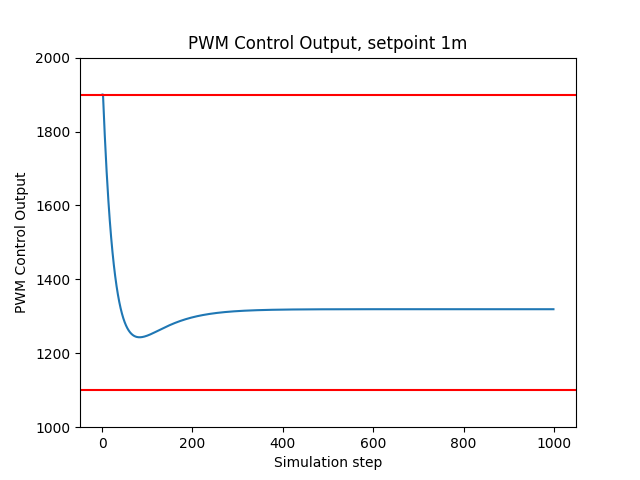

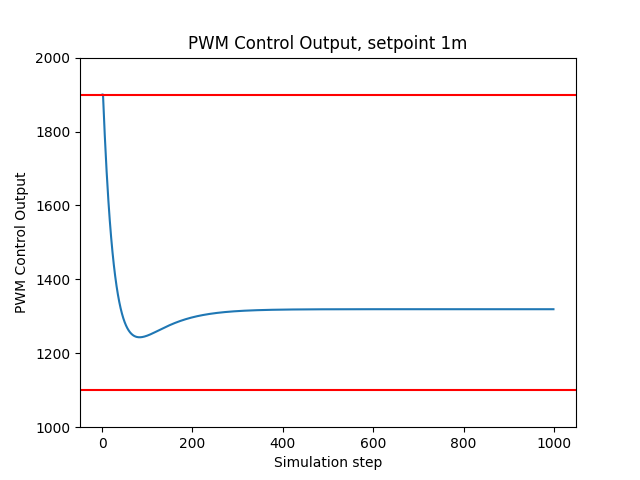

In [17]:
from student_pid_class import PID
Z_SETPOINT = 1      # Setpoint height [m]

test = TestPIDOutput(gains_path=GAINS_PATH,PID=PID,setpoint=Z_SETPOINT)

test.simulate_with_limits()


## Checkoff: 

Show that the Problem 3 loop quickly settles at the setpoint with little to no overshoot or oscillation. 
